/usr/local/lib64/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


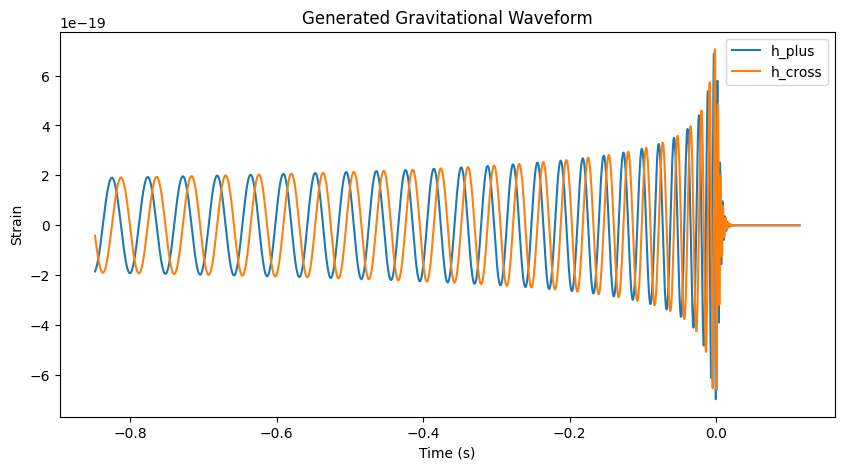

In [1]:
from pycbc.waveform import get_td_waveform

# Generar una señal de onda gravitacional
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/4096,
                         f_lower=20.0)

# Graficar la onda generada
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(hp.sample_times, hp, label="h_plus")
plt.plot(hc.sample_times, hc, label="h_cross")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Generated Gravitational Waveform")
plt.legend()
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


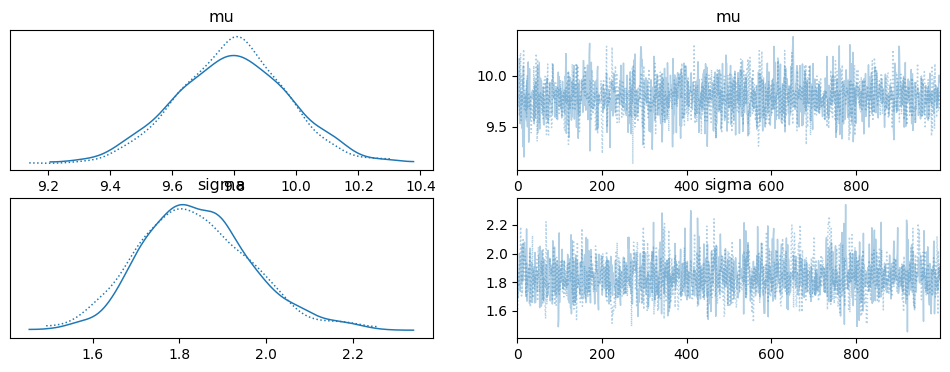

In [2]:
import pymc as pm
import numpy as np

# Datos simulados
np.random.seed(42)
x_data = np.random.normal(10, 2, 100)

# Modelo simple con PyMC
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=x_data)

    # Ajustar el modelo
    trace = pm.sample(1000, return_inferencedata=True)

# Mostrar resumen de los parámetros ajustados
import arviz as az
az.plot_trace(trace)
plt.show()


In [4]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform

# Simular señal observada (incluye ruido)
np.random.seed(42)
t = np.linspace(0, 1, 4096)  # Tiempo en segundos
hp_rom = 10 * np.sin(2 * np.pi * 100 * t)  # Señal original simulada (onda sinusoidal)
gaussian_noise = np.random.normal(scale=2, size=t.shape[0])
observed_signal = hp_rom + gaussian_noise

# Función para generar una señal modelo sin incluir la distancia
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4"):
    hp, _ = get_td_waveform(approximant=approximant,
                            mass1=mass1,
                            mass2=mass2,
                            delta_t=1.0/4096,
                            f_lower=20.0)
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Interpolación de señal
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para las masas
    mass1 = pm.Uniform("mass1", lower=5, upper=50)
    mass2 = pm.Uniform("mass2", lower=5, upper=50)

    # Likelihood personalizada
    def likelihood_function(mass1, mass2):
        try:
            model_signal = generate_model_signal(mass1, mass2)
            model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
            resampled_signal = interpolate_signal(model_signal, t, model_times)
            resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
            return resampled_signal
        except Exception as e:
            print(f"Error al generar la señal: {e}")
            return np.zeros_like(observed_signal)  # Retorna señal nula en caso de error

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=2, observed=observed_signal)

    # Iniciar el muestreo
    trace = pm.sample(1000, tune=500, chains=2)

# Resumen de los resultados
print(pm.summary(trace))

# Graficar resultados
pm.traceplot(trace)
plt.show()


Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mass1, mass2]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mass1  27.743  13.074   5.585   47.812      0.311    0.227    1722.0   
mass2  27.145  12.871   5.276   47.564      0.297    0.219    1753.0   

       ess_tail  r_hat  
mass1    1216.0    1.0  
mass2    1214.0    1.0  


FutureWarning: The function `traceplot` from PyMC was an alias for `plot_trace` from ArviZ. It was removed in PyMC 4.0. Switch to `pymc.plot_trace` or `arviz.plot_trace`.

         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mass1  27.743  13.074   5.585   47.812      0.311    0.227    1722.0   
mass2  27.145  12.871   5.276   47.564      0.297    0.219    1753.0   

       ess_tail  r_hat  
mass1    1216.0    1.0  
mass2    1214.0    1.0  


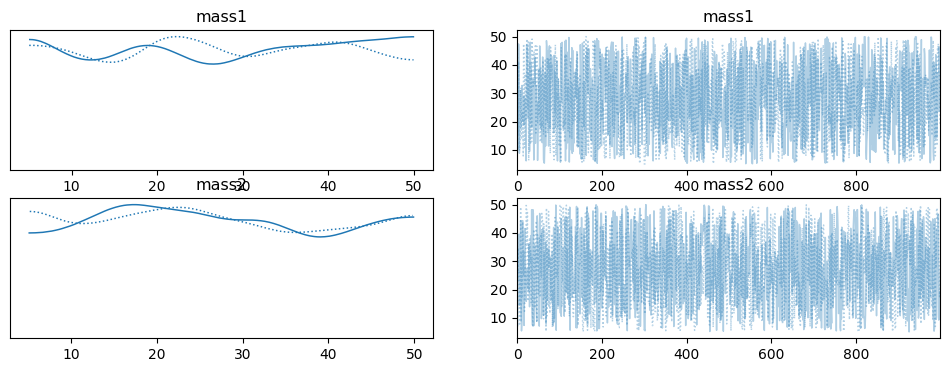

In [5]:
import arviz as az

# Resumen de los resultados
print(pm.summary(trace))

# Graficar resultados con ArviZ
az.plot_trace(trace)
plt.show()


Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mass1, mass2]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mass1  27.536  13.149   7.483   49.623      0.314    0.229    1690.0   
mass2  26.929  12.927   5.445   47.624      0.318    0.225    1543.0   

       ess_tail  r_hat  
mass1    1204.0    1.0  
mass2    1131.0    1.0  


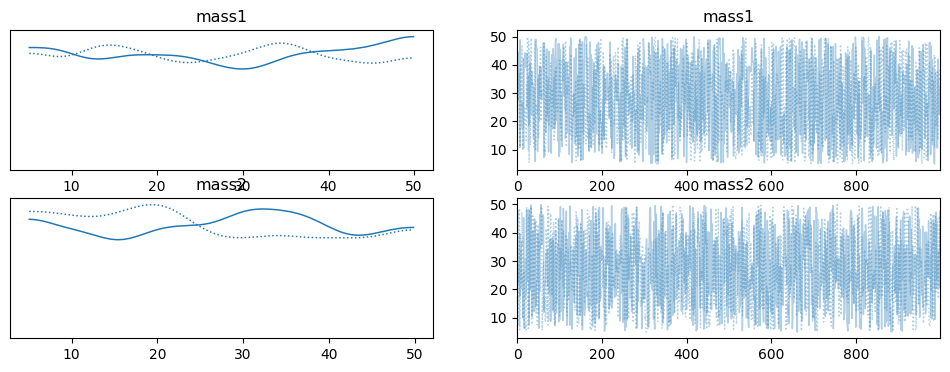

In [6]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az #PREGUNTAR
from pycbc.waveform import get_td_waveform

# Simular señal observada (incluye ruido)
np.random.seed(42)
t = np.linspace(0, 1, 4096)  # Tiempo en segundos
hp_rom = 10 * np.sin(2 * np.pi * 100 * t)  # Señal original simulada (onda sinusoidal)
gaussian_noise = np.random.normal(scale=2, size=t.shape[0])
observed_signal = hp_rom + gaussian_noise

# Generar una señal modelo
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4"):
    hp, _ = get_td_waveform(approximant=approximant,
                            mass1=mass1,
                            mass2=mass2,
                            delta_t=1.0/4096,
                            f_lower=20.0)
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Interpolación de señal
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para las masas
    mass1 = pm.Uniform("mass1", lower=5, upper=50)
    mass2 = pm.Uniform("mass2", lower=5, upper=50)

    # Likelihood 
    def likelihood_function(mass1, mass2):
        try:
            model_signal = generate_model_signal(mass1, mass2)
            model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
            resampled_signal = interpolate_signal(model_signal, t, model_times)
            resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
            return resampled_signal
        except Exception as e: #PREGUNTAR
            print(f"Error al generar la señal: {e}")
            return np.zeros_like(observed_signal)  # Retorna señal nula en caso de error

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=2, observed=observed_signal)

    # Iniciar el muestreo
    trace = pm.sample(1000, tune=500, chains=2)

# Resumen de los resultados
print(pm.summary(trace))

# Graficar resultados con ArviZ
az.plot_trace(trace)
plt.show()


Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mass1, mass2]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mass1  27.469  13.113   6.702   48.827      0.328    0.239    1536.0   
mass2  27.567  13.053   5.356   47.383      0.320    0.226    1545.0   

       ess_tail  r_hat  
mass1    1253.0    1.0  
mass2    1049.0    1.0  


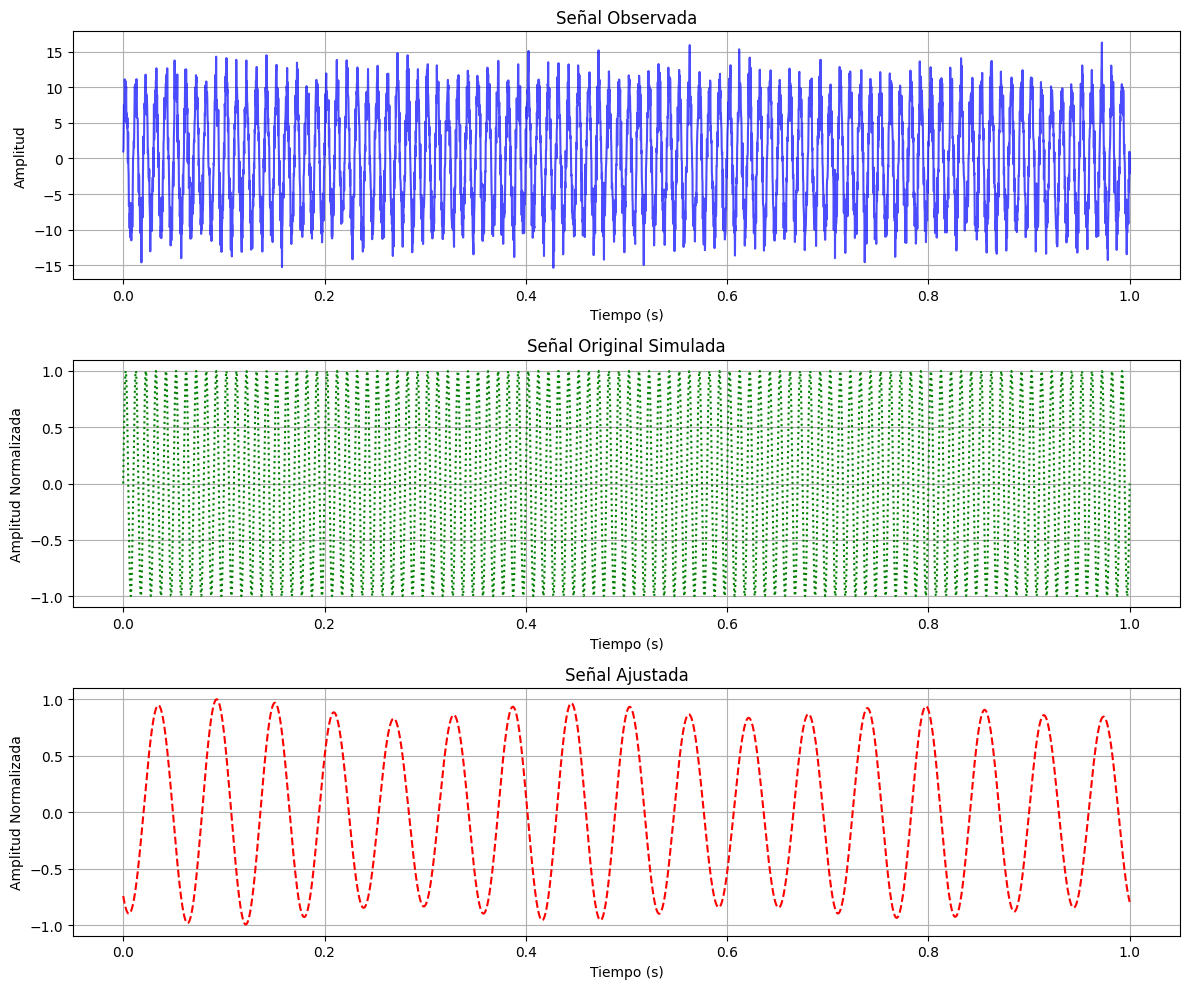

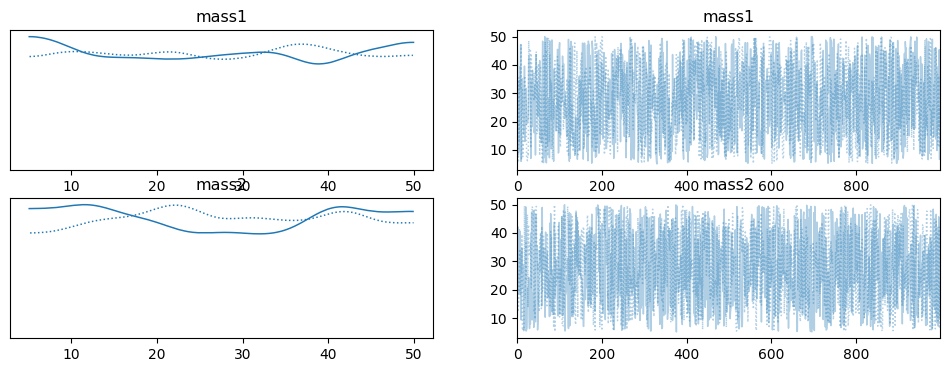

In [10]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az #(Revisar-Preguntar)
from pycbc.waveform import get_td_waveform

# Simulación Señal Observada
np.random.seed(42)
t = np.linspace(0, 1, 4096)
hp_rom = 10 * np.sin(2 * np.pi * 100 * t)  # Señal original simulada (Señal Base)
gaussian_noise = np.random.normal(scale=2, size=t.shape[0])
observed_signal = hp_rom + gaussian_noise

# Generar una señal modelo
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4_ROM"):
    hp, _ = get_td_waveform(approximant=approximant,
                            mass1=mass1,
                            mass2=mass2,
                            delta_t=1.0/4096,
                            f_lower=20.0)
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Interpolación de señal
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para las masas
    mass1 = pm.Uniform("mass1", lower=5, upper=50)
    mass2 = pm.Uniform("mass2", lower=5, upper=50)

    # Likelihood (Revisar bien-Preguntar)
    def likelihood_function(mass1, mass2):
        try:
            model_signal = generate_model_signal(mass1, mass2)
            model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
            resampled_signal = interpolate_signal(model_signal, t, model_times)
            resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
            return resampled_signal
        except Exception as e:   #PREGUNTAR
            print(f"Error al generar la señal: {e}")
            return np.zeros_like(observed_signal)  # Retorna señal nula en caso de error

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=2, observed=observed_signal)

    # Iniciar el muestreo
    trace = pm.sample(1000, tune=500, chains=2)

# Resultados
print(pm.summary(trace))

# Valores medios de las masas ajustadas
mass1_mean = trace.posterior['mass1'].mean().values
mass2_mean = trace.posterior['mass2'].mean().values

# Señal ajustada usando los valores promedio de las masas
adjusted_signal = generate_model_signal(mass1_mean, mass2_mean)
adjusted_times = np.linspace(0, len(adjusted_signal) / 4096, len(adjusted_signal))
adjusted_signal_resampled = interpolate_signal(adjusted_signal, t, adjusted_times)
adjusted_signal_resampled /= np.max(np.abs(adjusted_signal_resampled))

# Graficar señales
plt.figure(figsize=(12, 10))

# Señal observada
plt.subplot(3, 1, 1)
plt.plot(t, observed_signal, label="Señal Observada (con Ruido)", color='blue', alpha=0.7)
plt.title("Señal Observada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

# Señal original simulada
plt.subplot(3, 1, 2)
plt.plot(t, hp_rom / np.max(np.abs(hp_rom)), label="Señal Original (Simulada)", color='green', linestyle=':')
plt.title("Señal Original Simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

# Señal ajustada
plt.subplot(3, 1, 3)
plt.plot(t, adjusted_signal_resampled, label="Señal Ajustada", color='red', linestyle='--')
plt.title("Señal Ajustada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

plt.tight_layout()
# Graficar resultados con ArviZ
az.plot_trace(trace)
plt.show()

Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mass1, mass2]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mass1  27.392  13.154   5.208   47.435      0.304    0.215    1744.0   
mass2  27.612  13.171   7.775   49.962      0.319    0.228    1590.0   

       ess_tail  r_hat  
mass1    1131.0   1.00  
mass2    1098.0   1.01  


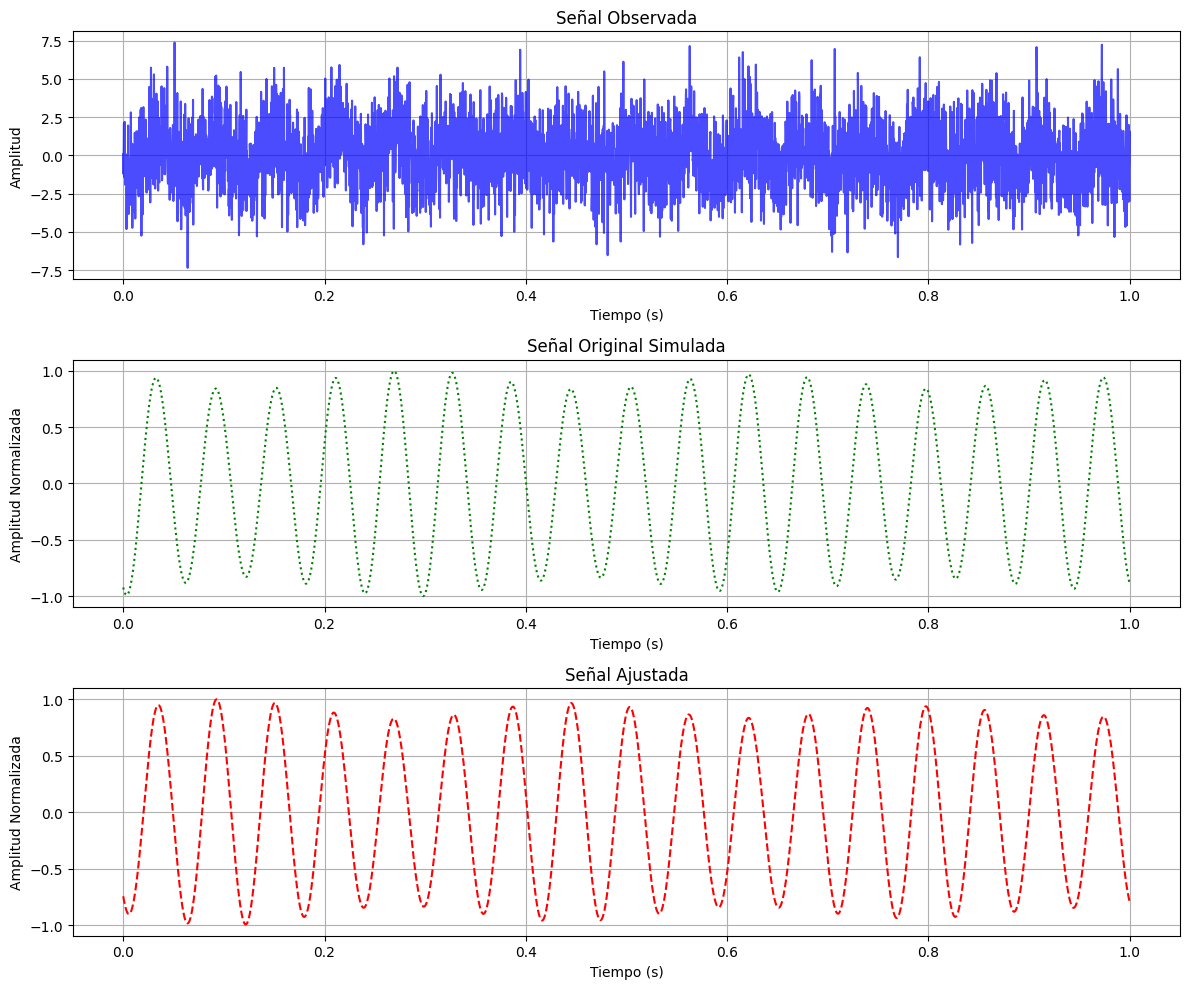

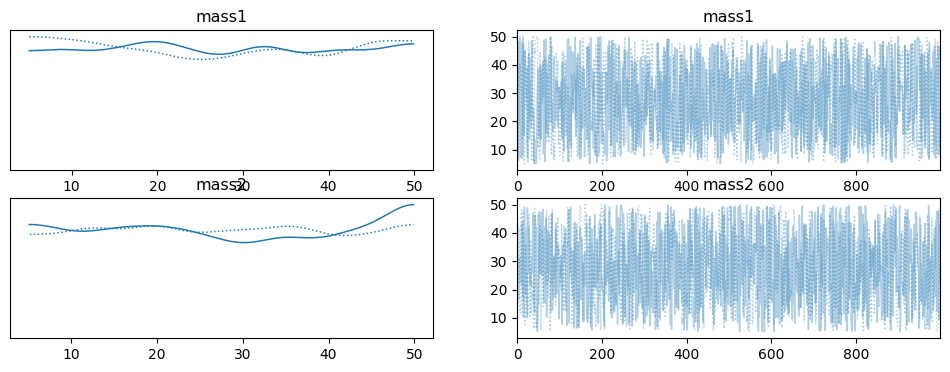

In [11]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pycbc.waveform import get_td_waveform

# Simulación Señal Observada
np.random.seed(42)
t = np.linspace(0, 1, 4096)

# Función para generar una señal modelo
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4_ROM"):
    hp, _ = get_td_waveform(approximant=approximant,
                            mass1=mass1,
                            mass2=mass2,
                            delta_t=1.0 / 4096,
                            f_lower=20.0)
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Función para interpolar señales
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Generar una señal base usando SEOBNRv4_ROM
model_signal_base = generate_model_signal(30, 30)  # Masses iniciales (30, 30)
model_times_base = np.linspace(0, len(model_signal_base) / 4096, len(model_signal_base))

# Resamplear la señal base para que coincida con tiempos observados
resampled_base_signal = interpolate_signal(model_signal_base, t, model_times_base)
resampled_base_signal /= np.max(np.abs(resampled_base_signal))  # Normalización

# Añadir ruido gaussiano a la señal base
gaussian_noise = np.random.normal(scale=2, size=t.shape[0])
observed_signal = resampled_base_signal + gaussian_noise

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para las masas
    mass1 = pm.Uniform("mass1", lower=5, upper=50)
    mass2 = pm.Uniform("mass2", lower=5, upper=50)

    # Likelihood (función de verosimilitud)
    def likelihood_function(mass1, mass2):
        try:
            model_signal = generate_model_signal(mass1, mass2)
            model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
            resampled_signal = interpolate_signal(model_signal, t, model_times)
            resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
            return resampled_signal
        except Exception as e:
            print(f"Error al generar la señal: {e}")
            return np.zeros_like(observed_signal)  # Retorna señal nula en caso de error

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=2, observed=observed_signal)

    # Iniciar el muestreo
    trace = pm.sample(1000, tune=500, chains=2)

# Resultados del ajuste
print(pm.summary(trace))

# Valores medios de las masas ajustadas
mass1_mean = trace.posterior['mass1'].mean().values
mass2_mean = trace.posterior['mass2'].mean().values

# Señal ajustada usando los valores promedio de las masas
adjusted_signal = generate_model_signal(mass1_mean, mass2_mean)
adjusted_times = np.linspace(0, len(adjusted_signal) / 4096, len(adjusted_signal))
adjusted_signal_resampled = interpolate_signal(adjusted_signal, t, adjusted_times)
adjusted_signal_resampled /= np.max(np.abs(adjusted_signal_resampled))

# Graficar señales
plt.figure(figsize=(12, 10))

# Señal observada
plt.subplot(3, 1, 1)
plt.plot(t, observed_signal, label="Señal Observada (con Ruido)", color='blue', alpha=0.7)
plt.title("Señal Observada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

# Señal original simulada
plt.subplot(3, 1, 2)
plt.plot(t, resampled_base_signal, label="Señal Original (Simulada)", color='green', linestyle=':')
plt.title("Señal Original Simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

# Señal ajustada
plt.subplot(3, 1, 3)
plt.plot(t, adjusted_signal_resampled, label="Señal Ajustada", color='red', linestyle='--')
plt.title("Señal Ajustada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

plt.tight_layout()

# Graficar resultados del muestreo
az.plot_trace(trace)
plt.show()


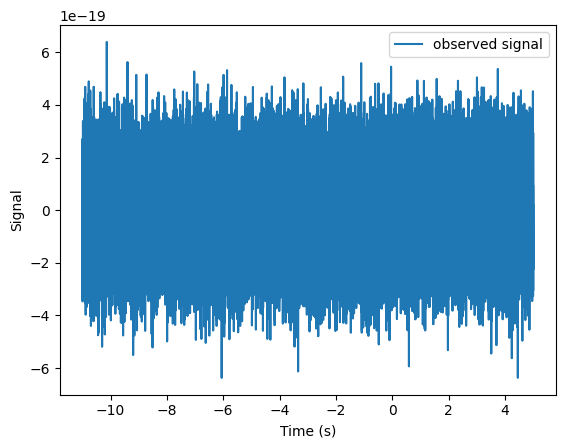

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from pycbc import waveform

# Generar la onda gravitacional
hp_rom, hc_rom = waveform.get_td_waveform(
                                approximant='SEOBNRv4_ROM',
                                mass1=6,
                                mass2=6,
                                delta_t=1.0/4096,
                                f_lower=40
                                 )

# Extraer tiempos de muestreo ANTES de convertir a numpy.ndarray
t = hp_rom.sample_times  # Esto accede a los tiempos de muestreo del objeto PyCBC.

# Convertir la señal a numpy.ndarray para su procesamiento
hp_rom = np.array(hp_rom)

# Generar ruido gaussiano
gaussian_noise = np.random.normal(size=t.shape[0])

# Escalar el ruido para igualar la amplitud máxima de la señal
max_value = np.max(np.abs(hp_rom))
scaled_noise = gaussian_noise * max_value

# Generar la señal observada
observed_signal = hp_rom + scaled_noise

# Graficar la señal observada
plt.plot(t, observed_signal, label='observed signal')
plt.legend()
plt.ylabel('Signal')
plt.xlabel('Time (s)')
plt.show()


Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mass1, mass2]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mass1  27.727  13.084   5.652   47.802       0.31    0.220    1595.0   
mass2  27.445  13.398   5.026   47.705       0.31    0.222    1638.0   

       ess_tail  r_hat  
mass1    1265.0    1.0  
mass2    1049.0    1.0  


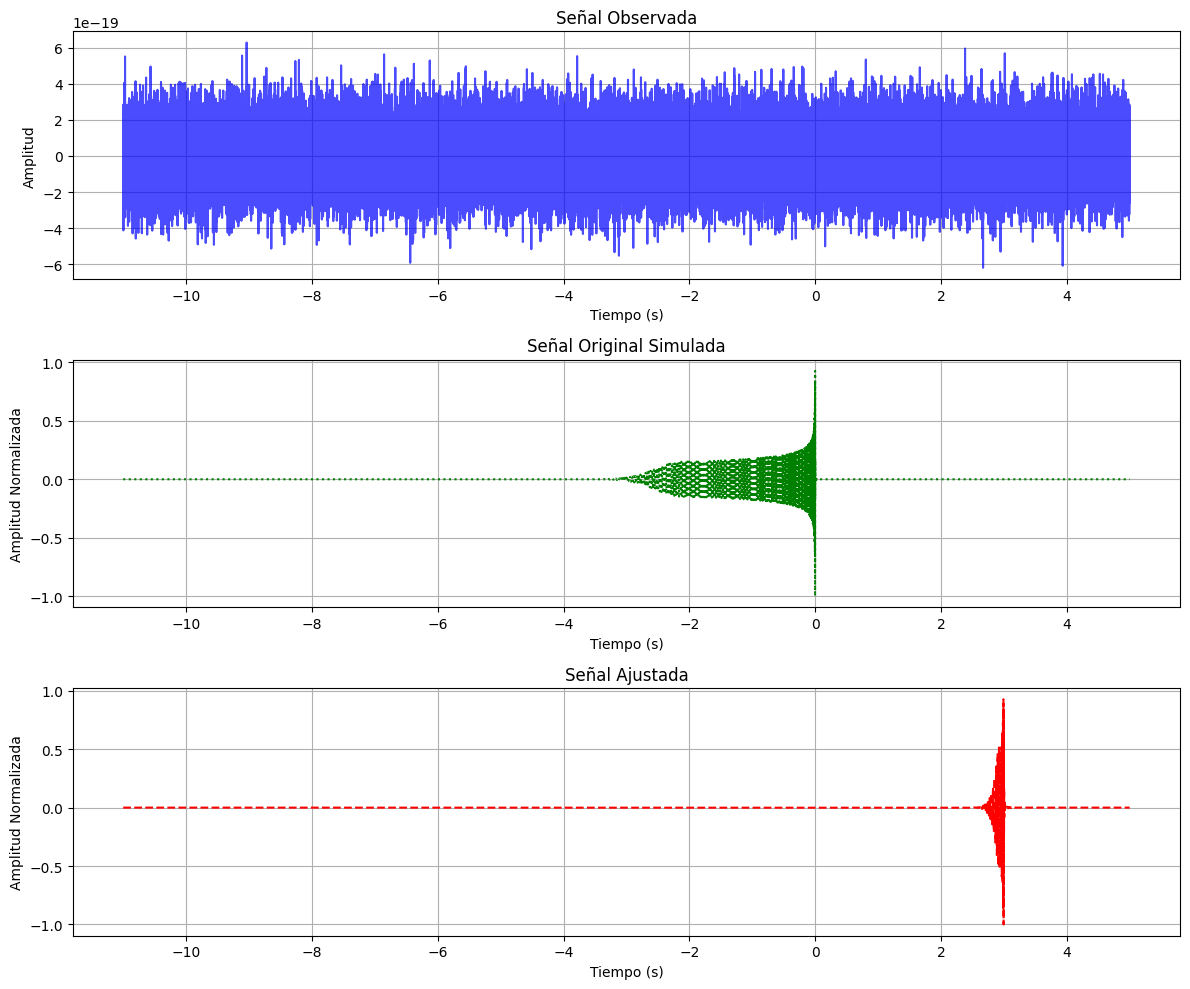

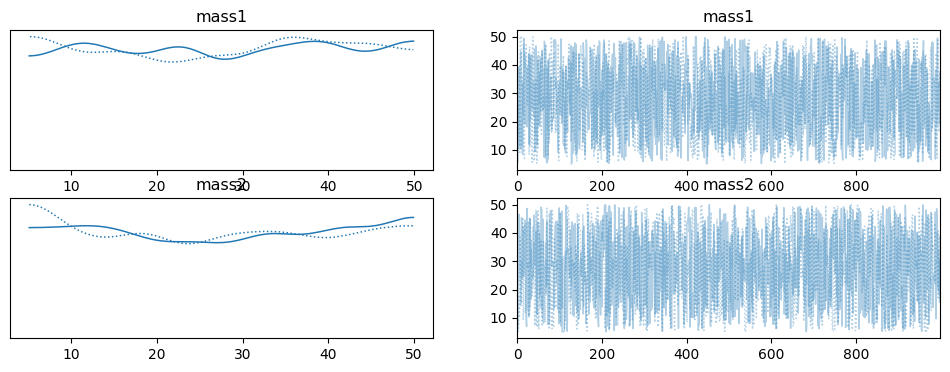

In [9]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pycbc.waveform import get_td_waveform

# Generar la onda gravitacional
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=1.0 / 4096,
    f_lower=40
)

# Extraer tiempos de muestreo ANTES de convertir a numpy.ndarray
t = hp_rom.sample_times  # Esto accede a los tiempos de muestreo del objeto PyCBC.

# Convertir la señal a numpy.ndarray para su procesamiento
hp_rom = np.array(hp_rom)

# Generar ruido gaussiano
gaussian_noise = np.random.normal(size=t.shape[0])

# Escalar el ruido para igualar la amplitud máxima de la señal
max_value = np.max(np.abs(hp_rom))
scaled_noise = gaussian_noise * max_value

# Generar la señal observada
observed_signal = hp_rom + scaled_noise

# Generar una señal modelo
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4_ROM"):
    hp, _ = get_td_waveform(
        approximant=approximant,
        mass1=mass1,
        mass2=mass2,
        delta_t=1.0 / 4096,
        f_lower=40.0
    )
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Interpolación de señal
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para las masas
    mass1 = pm.Uniform("mass1", lower=5, upper=50)
    mass2 = pm.Uniform("mass2", lower=5, upper=50)

    # Likelihood (Revisar bien-Preguntar)
    def likelihood_function(mass1, mass2):
        try:
            model_signal = generate_model_signal(mass1, mass2)
            model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
            resampled_signal = interpolate_signal(model_signal, t, model_times)
            resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
            return resampled_signal
        except Exception as e:
            print(f"Error al generar la señal: {e}")
            return np.zeros_like(observed_signal)  # Retorna señal nula en caso de error

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=2, observed=observed_signal)

    # Iniciar el muestreo
    trace = pm.sample(1000, tune=500, chains=2)

# Resultados
print(pm.summary(trace))

# Valores medios de las masas ajustadas
mass1_mean = trace.posterior['mass1'].mean().values
mass2_mean = trace.posterior['mass2'].mean().values

# Señal ajustada usando los valores promedio de las masas
adjusted_signal = generate_model_signal(mass1_mean, mass2_mean)
adjusted_times = np.linspace(0, len(adjusted_signal) / 4096, len(adjusted_signal))
adjusted_signal_resampled = interpolate_signal(adjusted_signal, t, adjusted_times)
adjusted_signal_resampled /= np.max(np.abs(adjusted_signal_resampled))

# Graficar señales
plt.figure(figsize=(12, 10))

# Señal observada
plt.subplot(3, 1, 1)
plt.plot(t, observed_signal, label="Señal Observada (con Ruido)", color='blue', alpha=0.7)
plt.title("Señal Observada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

# Señal original simulada
plt.subplot(3, 1, 2)
plt.plot(t, hp_rom / np.max(np.abs(hp_rom)), label="Señal Original (Simulada)", color='green', linestyle=':')
plt.title("Señal Original Simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

# Señal ajustada
plt.subplot(3, 1, 3)
plt.plot(t, adjusted_signal_resampled, label="Señal Ajustada", color='red', linestyle='--')
plt.title("Señal Ajustada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

plt.tight_layout()
# Graficar resultados con ArviZ
az.plot_trace(trace)
plt.show()


Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mass1, mass2]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 22 seconds.


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mass1  27.562  12.821   5.472   47.316      0.247    0.178    2462.0   
mass2  27.784  13.039   7.506   49.911      0.259    0.188    2399.0   

       ess_tail  r_hat  
mass1    2062.0    1.0  
mass2    1811.0    1.0  


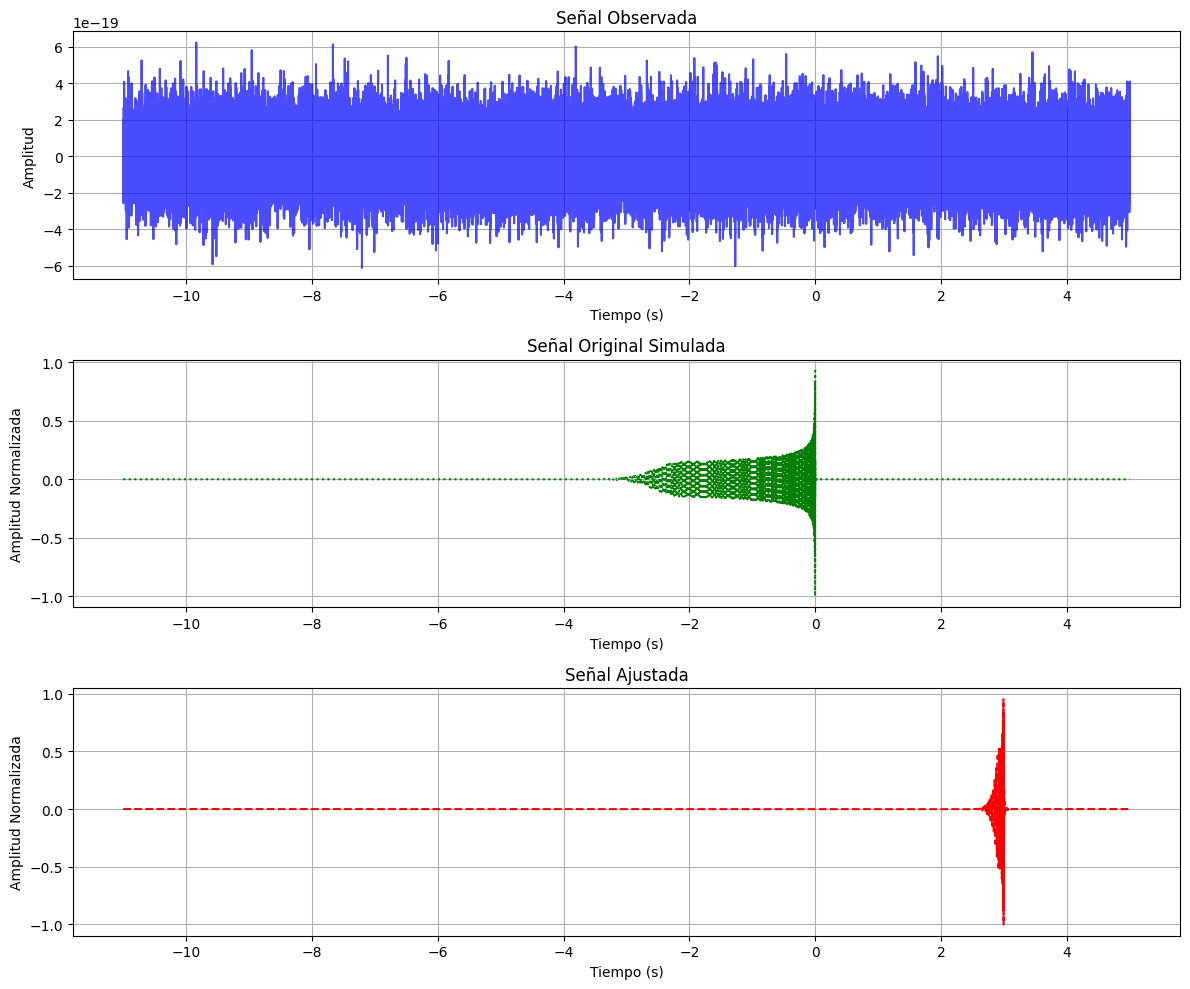

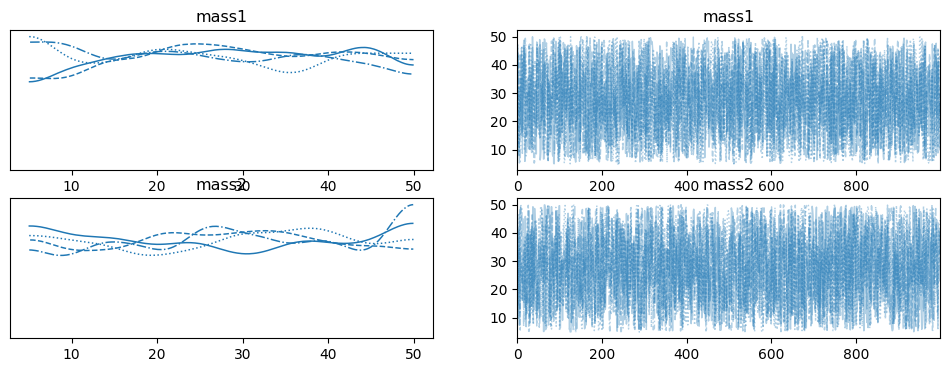

In [14]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pycbc.waveform import get_td_waveform

# Generar la onda gravitacional
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=1.0 / 4096,
    f_lower=40
)

# Extraer tiempos de muestreo ANTES de convertir a numpy.ndarray
t = hp_rom.sample_times  # Esto accede a los tiempos de muestreo del objeto PyCBC.

# Convertir la señal a numpy.ndarray para su procesamiento
hp_rom = np.array(hp_rom)

# Generar ruido gaussiano
gaussian_noise = np.random.normal(size=t.shape[0])

# Escalar el ruido para igualar la amplitud máxima de la señal
max_value = np.max(np.abs(hp_rom))
scaled_noise = gaussian_noise * max_value

# Generar la señal observada
observed_signal = hp_rom + scaled_noise

# Generar una señal modelo
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4_ROM"):
    hp, _ = get_td_waveform(
        approximant=approximant,
        mass1=mass1,
        mass2=mass2,
        delta_t=1.0 / 4096,
        f_lower=40.0
    )
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Interpolación de señal
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para las masas
    mass1 = pm.Uniform("mass1", lower=5, upper=50)
    mass2 = pm.Uniform("mass2", lower=5, upper=50)

    # Likelihood (Revisar bien-Preguntar)
    def likelihood_function(mass1, mass2):
        try:
            model_signal = generate_model_signal(mass1, mass2)
            model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
            resampled_signal = interpolate_signal(model_signal, t, model_times)
            resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
            return resampled_signal
        except Exception as e:
            print(f"Error al generar la señal: {e}")
            return np.zeros_like(observed_signal)  # Retorna señal nula en caso de error

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=2, observed=observed_signal)

    # Iniciar el muestreo
    trace = pm.sample(1000, chains=4, target_accept=0.95, tune=3000, random_seed=42)

# Resultados
print(pm.summary(trace))

# Valores medios de las masas ajustadas
mass1_mean = trace.posterior['mass1'].mean().values
mass2_mean = trace.posterior['mass2'].mean().values

# Señal ajustada usando los valores promedio de las masas
adjusted_signal = generate_model_signal(mass1_mean, mass2_mean)
adjusted_times = np.linspace(0, len(adjusted_signal) / 4096, len(adjusted_signal))
adjusted_signal_resampled = interpolate_signal(adjusted_signal, t, adjusted_times)
adjusted_signal_resampled /= np.max(np.abs(adjusted_signal_resampled))

# Graficar señales
plt.figure(figsize=(12, 10))

# Señal observada
plt.subplot(3, 1, 1)
plt.plot(t, observed_signal, label="Señal Observada (con Ruido)", color='blue', alpha=0.7)
plt.title("Señal Observada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

# Señal original simulada
plt.subplot(3, 1, 2)
plt.plot(t, hp_rom / np.max(np.abs(hp_rom)), label="Señal Original (Simulada)", color='green', linestyle=':')
plt.title("Señal Original Simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

# Señal ajustada
plt.subplot(3, 1, 3)
plt.plot(t, adjusted_signal_resampled, label="Señal Ajustada", color='red', linestyle='--')
plt.title("Señal Ajustada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

plt.tight_layout()
# Graficar resultados con ArviZ
az.plot_trace(trace)
plt.show()

/usr/local/lib64/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mass1, mass2]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 22 seconds.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mass1  6.003  0.570   5.021    6.881      0.011    0.008    2462.0    2062.0   
mass2  6.013  0.579   5.111    6.996      0.011    0.008    2399.0    1811.0   

       r_hat  
mass1    1.0  
mass2    1.0  


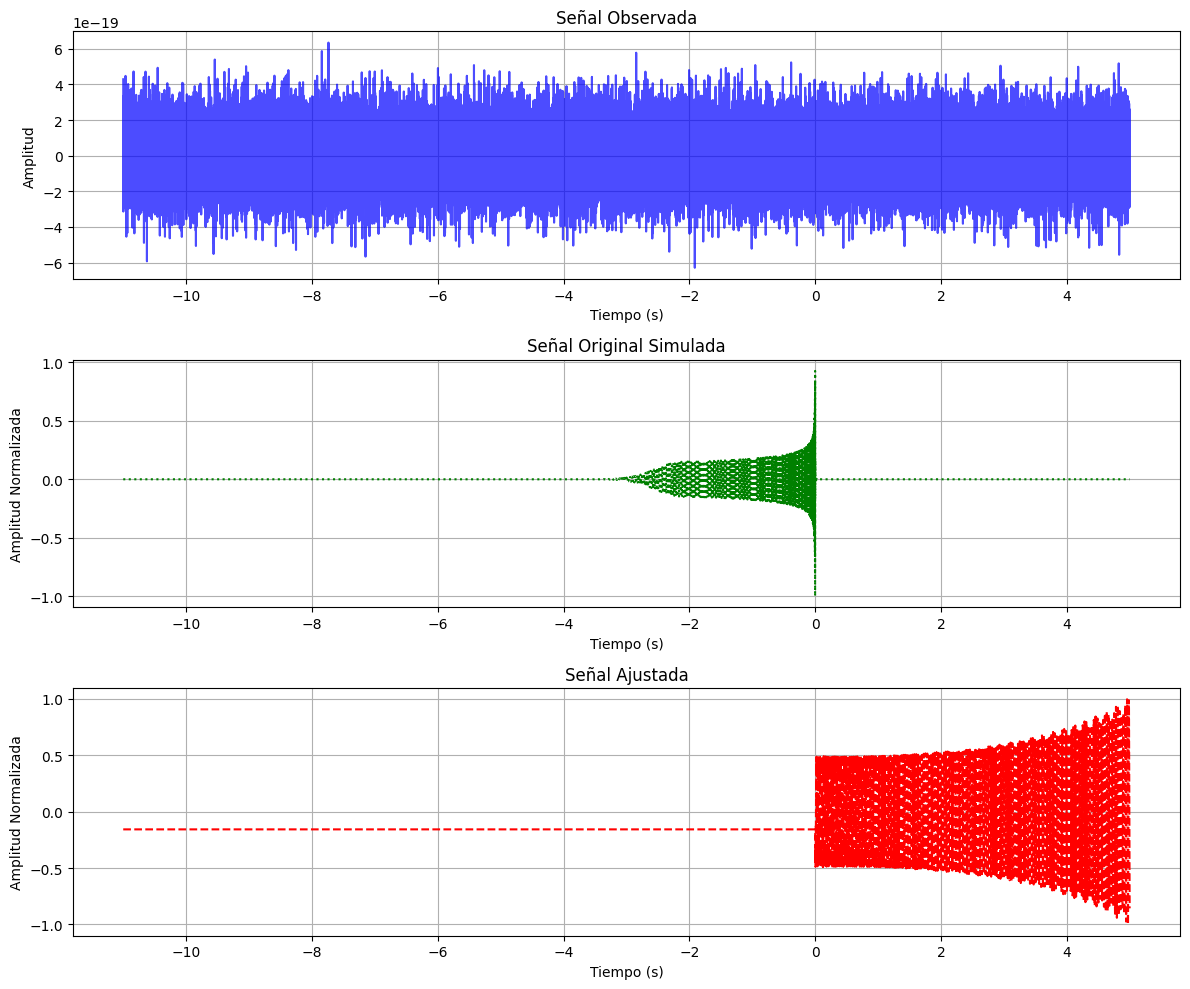

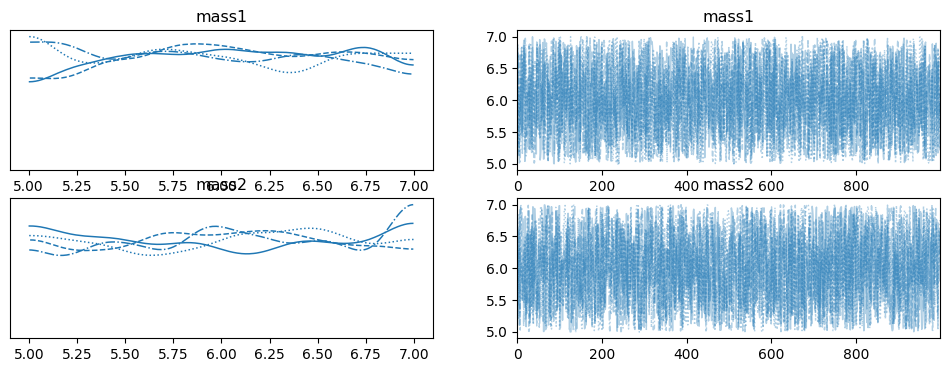

In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pycbc.waveform import get_td_waveform

# Generar la onda gravitacional
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=1.0 / 4096,
    f_lower=40
)

# Extraer tiempos de muestreo ANTES de convertir a numpy.ndarray
t = hp_rom.sample_times  # Esto accede a los tiempos de muestreo del objeto PyCBC.

# Convertir la señal a numpy.ndarray para su procesamiento
hp_rom = np.array(hp_rom)

# Generar ruido gaussiano
gaussian_noise = np.random.normal(size=t.shape[0])

# Escalar el ruido para igualar la amplitud máxima de la señal
max_value = np.max(np.abs(hp_rom))
scaled_noise = gaussian_noise * max_value

# Generar la señal observada
observed_signal = hp_rom + scaled_noise

# Generar una señal modelo
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4_ROM"):
    hp, _ = get_td_waveform(
        approximant=approximant,
        mass1=mass1,
        mass2=mass2,
        delta_t=1.0 / 4096,
        f_lower=40.0
    )
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Interpolación de señal
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para las masas
    mass1 = pm.Uniform("mass1", lower=5, upper=7)
    mass2 = pm.Uniform("mass2", lower=5, upper=7)

    # Likelihood (Revisar bien-Preguntar)
    def likelihood_function(mass1, mass2):
        try:
            model_signal = generate_model_signal(mass1, mass2)
            model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
            resampled_signal = interpolate_signal(model_signal, t, model_times)
            resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
            return resampled_signal
        except Exception as e:
            print(f"Error al generar la señal: {e}")
            return np.zeros_like(observed_signal)  # Retorna señal nula en caso de error

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=2, observed=observed_signal)

    # Iniciar el muestreo
    trace = pm.sample(1000, chains=4, target_accept=0.95, tune=3000, random_seed=42)

# Resultados
print(pm.summary(trace))

# Valores medios de las masas ajustadas
mass1_mean = trace.posterior['mass1'].mean().values
mass2_mean = trace.posterior['mass2'].mean().values

# Señal ajustada usando los valores promedio de las masas
adjusted_signal = generate_model_signal(mass1_mean, mass2_mean)
adjusted_times = np.linspace(0, len(adjusted_signal) / 4096, len(adjusted_signal))
adjusted_signal_resampled = interpolate_signal(adjusted_signal, t, adjusted_times)
adjusted_signal_resampled /= np.max(np.abs(adjusted_signal_resampled))

# Graficar señales
plt.figure(figsize=(12, 10))

# Señal observada
plt.subplot(3, 1, 1)
plt.plot(t, observed_signal, label="Señal Observada (con Ruido)", color='blue', alpha=0.7)
plt.title("Señal Observada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

# Señal original simulada
plt.subplot(3, 1, 2)
plt.plot(t, hp_rom / np.max(np.abs(hp_rom)), label="Señal Original (Simulada)", color='green', linestyle=':')
plt.title("Señal Original Simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

# Señal ajustada
plt.subplot(3, 1, 3)
plt.plot(t, adjusted_signal_resampled, label="Señal Ajustada", color='red', linestyle='--')
plt.title("Señal Ajustada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

plt.tight_layout()
# Graficar resultados con ArviZ
az.plot_trace(trace)
plt.show()

Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mass1, mass2]


Sampling 4 chains for 3_000 tune and 8_000 draw iterations (12_000 + 32_000 draws total) took 57 seconds.


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mass1  27.392  12.878   5.153   47.235      0.087    0.062   20271.0   
mass2  27.425  13.020   5.356   47.650      0.090    0.064   19231.0   

       ess_tail  r_hat  
mass1   16293.0    1.0  
mass2   15580.0    1.0  


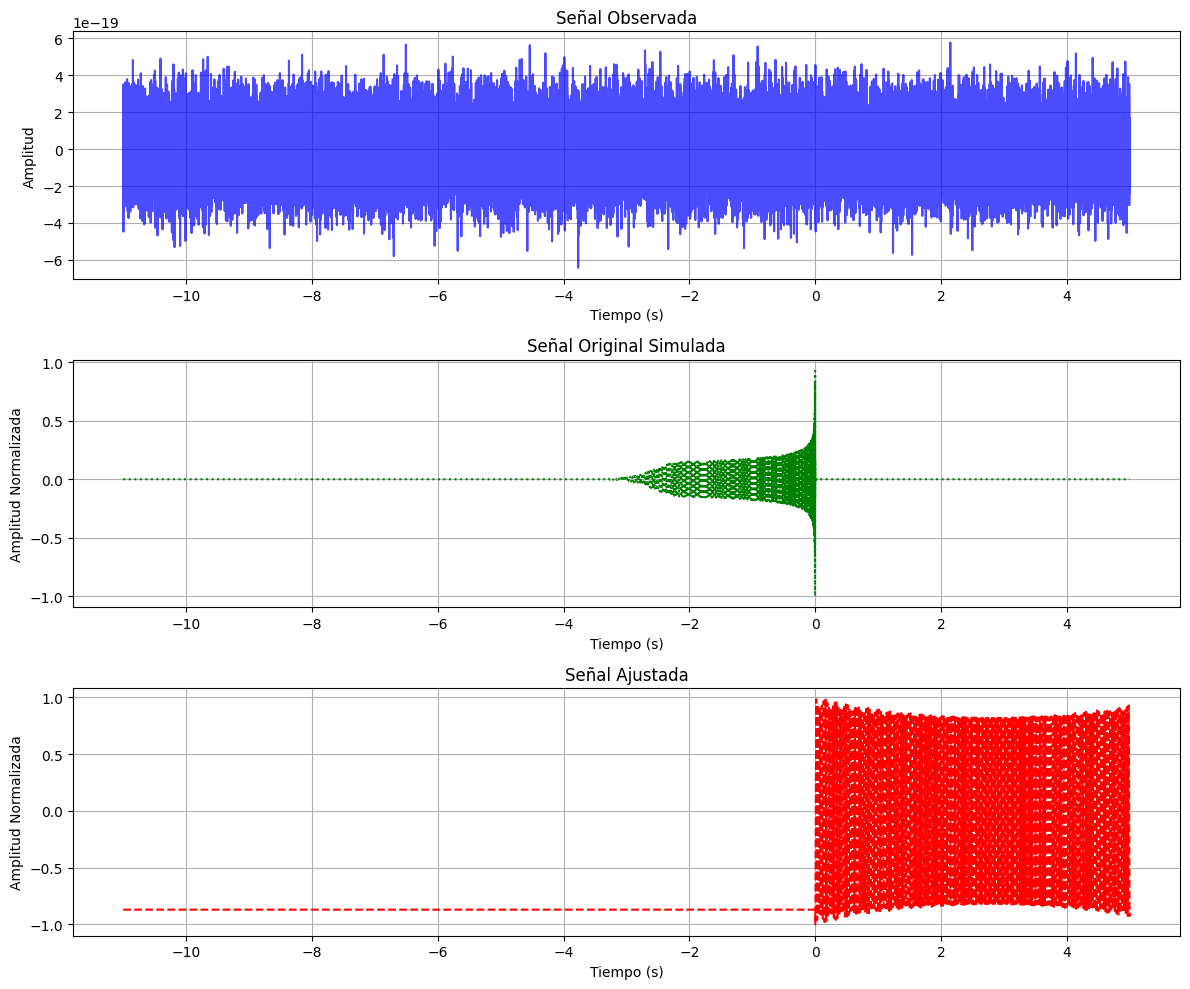

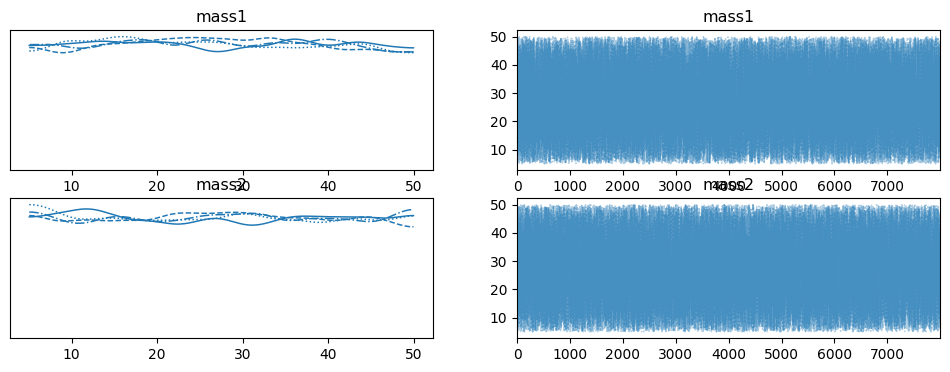

In [4]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pycbc.waveform import get_td_waveform

# Generar la onda gravitacional
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=1.0 / 4096,
    f_lower=40
)

# Extraer tiempos de muestreo ANTES de convertir a numpy.ndarray
t = hp_rom.sample_times  # Esto accede a los tiempos de muestreo del objeto PyCBC.

# Convertir la señal a numpy.ndarray para su procesamiento
hp_rom = np.array(hp_rom)

# Generar ruido gaussiano
gaussian_noise = np.random.normal(size=t.shape[0])

# Escalar el ruido para igualar la amplitud máxima de la señal
max_value = np.max(np.abs(hp_rom))
scaled_noise = gaussian_noise * max_value

# Generar la señal observada
observed_signal = hp_rom + scaled_noise

# Generar una señal modelo
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4_ROM"):
    hp, _ = get_td_waveform(
        approximant=approximant,
        mass1=mass1,
        mass2=mass2,
        delta_t=1.0 / 4096,
        f_lower=40.0
    )
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Interpolación de señal
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para las masas
    mass1 = pm.Uniform("mass1", lower=5, upper=50)
    mass2 = pm.Uniform("mass2", lower=5, upper=50)

    # Likelihood (Revisar bien-Preguntar)
    def likelihood_function(mass1, mass2):
        try:
            model_signal = generate_model_signal(mass1, mass2)
            model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
            resampled_signal = interpolate_signal(model_signal, t, model_times)
            resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
            return resampled_signal
        except Exception as e:
            print(f"Error al generar la señal: {e}")
            return np.zeros_like(observed_signal)  # Retorna señal nula en caso de error

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=0.5, observed=observed_signal)

    # Iniciar el muestreo
    trace = pm.sample(8000, chains=4, target_accept=0.95, tune=3000, random_seed=42)

# Resultados
print(pm.summary(trace))

# Valores medios de las masas ajustadas
mass1_mean = trace.posterior['mass1'].mean().values
mass2_mean = trace.posterior['mass2'].mean().values

# Señal ajustada usando los valores promedio de las masas
adjusted_signal = generate_model_signal(mass1_mean, mass2_mean)
adjusted_times = np.linspace(0, len(adjusted_signal) / 4096, len(adjusted_signal))
adjusted_signal_resampled = interpolate_signal(adjusted_signal, t, adjusted_times)
adjusted_signal_resampled /= np.max(np.abs(adjusted_signal_resampled))

# Graficar señales
plt.figure(figsize=(12, 10))

# Señal observada
plt.subplot(3, 1, 1)
plt.plot(t, observed_signal, label="Señal Observada (con Ruido)", color='blue', alpha=0.7)
plt.title("Señal Observada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

# Señal original simulada
plt.subplot(3, 1, 2)
plt.plot(t, hp_rom / np.max(np.abs(hp_rom)), label="Señal Original (Simulada)", color='green', linestyle=':')
plt.title("Señal Original Simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

# Señal ajustada
plt.subplot(3, 1, 3)
plt.plot(t, adjusted_signal_resampled, label="Señal Ajustada", color='red', linestyle='--')
plt.title("Señal Ajustada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

plt.tight_layout()
# Graficar resultados con ArviZ
az.plot_trace(trace)
plt.show()